# Quaternion Model

This model begins with the following Free Energy functional, with terms taken from Pusztai2005 and Dorr2010:

$$ F = \int_V (\frac{\epsilon_\phi^2T}{2}|\nabla \phi|^2 + f(\phi,c) + f_{ori}) dV \qquad (1)$$ 

In this equation, the bulk free energy, and the orientational mismatch energy are represented by the following equations:

$$ f(\phi, c) = Wg(\phi) + p(\phi)f_S + (1-p(\phi)f_L \qquad (2)$$

$$ 

In [902]:
%matplotlib inline
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

In [994]:
def __h(phi):
    return phi*phi*phi*(10-15*phi+6*phi*phi)

def __hprime(phi):
    return (30*phi*phi*(1-phi)*(1-phi))

def __g(phi):
    return (16*phi*phi*(1-phi)*(1-phi))

def __gprime(phi):
    return (64*phi*phi*phi - 96*phi*phi +32*phi)

_h = np.vectorize(__h)
_hprime = np.vectorize(__hprime)
_g = np.vectorize(__g) 
_gprime = np.vectorize(__gprime)

def grad(phi, dx, dim):
    r = []
    for i in range(dim):
        phim = np.roll(phi, 1, i)
        phip = np.roll(phi, -1, i)
        r.append((phip-phim)/(2*dx))
    return r

def grad_l(phi, dx, i):
    r = []
    for i in range(dim):
        phim = np.roll(phi, 1, i)
        r.append((phi-phim)/(dx))
    return r

def grad_r(phi, dx, i):
    r = []
    for i in range(dim):
        phip = np.roll(phi, -1, i)
        r.append((phip-phi)/(dx))
    return r

def grad2(phi, dx, dim):
    r = np.zeros_like(phi)
    for i in range(dim):
        phim = np.roll(phi, 1, i)
        phip = np.roll(phi, -1, i)
        r += (phip+phim-2*phi)/(dx*dx)
    return r

def divagradb(a, b, dx, dim):
    r = np.zeros_like(b)
    for i in range(dim):
        agradb = ((a + np.roll(a, -1, i))/2)*(np.roll(b, -1, i) - b)/dx
        r += (agradb - np.roll(agradb, 1, i))/dx
    return r

def gaq(gql, gqr, rgqsl, rgqsr, dqc, dx, dim):
    r = np.zeros_like(dqc)
    for i in range(dim):
        r += ((0.5*(dqc+np.roll(dqc, -1, i))*gqr[i]/rgqsr[i])-(0.5*(dqc+np.roll(dqc, 1, i))*gql[i]/rgqsl[i]))/(dx)
    return r

def renormalize(q1, q2, q3, q4):
    q = np.sqrt(q1*q1+q2*q2+q3*q3+q4*q4)
    return q1/q, q2/q, q3/q, q4/q

def loadArrays(path, timestep):
    _q1 = np.load(path+'q1_'+str(timestep)+'.npy')
    _q2 = np.load(path+'q2_'+str(timestep)+'.npy')
    _q3 = np.load(path+'q3_'+str(timestep)+'.npy')
    _q4 = np.load(path+'q4_'+str(timestep)+'.npy')
    _c = np.load(path+'c_'+str(timestep)+'.npy')
    _phi = np.load(path+'phi_'+str(timestep)+'.npy')
    return timestep, _c, _phi, _q1, _q2, _q3, _q4

def saveArrays(path, timestep, c, phi, q1, q2, q3, q4):
    np.save(path+'phi_'+str(timestep), phi)
    np.save(path+'c_'+str(timestep), c)
    np.save(path+'q1_'+str(timestep), q1)
    np.save(path+'q2_'+str(timestep), q2)
    np.save(path+'q3_'+str(timestep), q3)
    np.save(path+'q4_'+str(timestep), q4)

In [725]:
#temperature
T = 873.

#bcc = 0L = e, fcc = 1S = d
#material parameters, pJ, um, K, s (except for R and Q terms, which use joules)
R = 8.314 #gas constant, J/mol*K
Q_d = 156400. #activation term in diffusivity in fcc region, J/mol
Q_e = 55290. #activation term in diffusivity in bcc region, J/mol
ceq_d = 0.1 #equilibrium concentration in fcc
ceq_e = 0.05 #equilibrium concentration in bcc
D_d0 = 1.3e8 #scaling constant of diffusion in fcc, um^2/s
D_e0 = 5.6e4 #scaling constant of diffusion in fcc, um^2/s
M_phi = 200 #mobility of phase, 1/(s*pJ)
M_qmax = 200 #maximum mobility of orientation, 1/(s*pJ)
H = 1e-3 #interfacial energy term for quaternions, pJ/(K*um)
A = 666. #energetic term in HBSM binary alloy model, A_d = A_e
w = 0.4125 #scaling of energetic hump forcing phase to be 0,1

#Temperature dependent params, since T is constant, we compute them here for now
D_d = D_d0 * np.exp(-Q_d/(R*T))
D_e = D_e0 * np.exp(-Q_e/(R*T))
print(D_d, D_e)

(0.056970096381563029, 27.534340424588464)


In [1014]:
#this code block initializes the simulation

np.set_printoptions(threshold=np.inf)

shape = []
dim = 2
res = 128
for i in range(dim):
    shape.append(res)

dx = 0.05
dt = dx*dx/5./D_e #old value for Courant stability, not sufficient for quaternion stability. Use beta = 1.5ish
dt = 1.48e-7 #10 million time steps to run Dorr's simulation
d = dx*4 #interfacial thickness
ebar = 0.165 
eqbar = 0.1
print(dt)

c = np.zeros(shape)
phi = np.zeros(shape)
q1 = np.zeros(shape)
q2 = np.zeros(shape)
q3 = np.zeros(shape)
q4 = np.zeros(shape)
q1 += 1
c += 0.06
#c += 0.001*np.random.rand(res, res)

#phi[0:res/4] = 1
#q1[0:res/4] = np.cos(np.pi/8)
#q2[0:res/4] = np.sin(np.pi/8)
#c[0:res/4] = 0.1

#phi[3*res/4:res] = 1
#q1[3*res/4:res] = np.cos(np.pi/8)
#q2[3*res/4:res] = np.sin(np.pi/8)
#c[3*res/4:res] = 0.1

#phi = np.transpose(phi)
#q1 = np.transpose(q1)
#q2 = np.transpose(q2)
#c = np.transpose(c)

for i in range(res):
    for j in range(res):
        if((i-80+0.5)*(i-80+0.5)+(j-48+0.5)*(j-48+0.5) < 100):
            phi[i][j] = 1
            q1[i][j] = np.cos(np.pi/8)
            q2[i][j] = np.sin(np.pi/8)
            c[i][j] = 0.1
        if((i-48+0.5)*(i-48+0.5)+(j-80+0.5)*(j-80+0.5) < 225):
            phi[i][j] = 1
            q1[i][j] = np.cos(np.pi/8)
            q3[i][j] = np.sin(np.pi/8)
            c[i][j] = 0.1
    
#print(q1)
#print(q2)

reference = np.zeros(res)
for i in range(res):
    reference[i] = i

step = 0

1.48e-07


In [1022]:
# This block runs the simulation for some number of time steps

#add these values after evolving the simulation to almost stability - to test if the interface in phi is truly stable
#phi = np.zeros(res)
#phi += 1

time_steps = 10000

# original number is the one used in Pusztai2005 and Granasy2014
# multiplication factor is used to ensure q is stable

for i in range(time_steps):
    step += 1
    #print(i)
    g = _g(phi)
    h = _h(phi)
    m = 1-h;
    
    lq1 = grad2(q1, dx, dim)
    lq2 = grad2(q2, dx, dim)
    lq3 = grad2(q3, dx, dim)
    lq4 = grad2(q4, dx, dim)
    
    #this term is to evolve just the orientation, as done before the first real time step in the Dorr paper
    only_orientation = False
    
    if(only_orientation):
        deltac = 0
        deltaphi = 0
        gaq1 = 0
        gaq2 = 0
        gaq3 = 0
        gaq4 = 0
        
    else:
        #additional interpolating functions
        p = phi*phi
        pp = 2*phi
        hprime = _hprime(phi)
        gprime = _gprime(phi)
    
        #bulk energy terms, using HBSM model (Hu2007)
        c_d = c - m*(ceq_e - ceq_d)
        c_e = c - h*(ceq_d - ceq_e)
        f_d = A*(c_d - ceq_d)*(c_d - ceq_d)
        f_e = A*(c_e - ceq_e)*(c_e - ceq_e)
        mu = h*2*A*(c_d - ceq_d) + m*2*A*(c_e - ceq_e)
    
        #quaternion gradient terms
        gq1l = grad_l(q1, dx, dim)
        gq2l = grad_l(q2, dx, dim)
        gq3l = grad_l(q3, dx, dim)
        gq4l = grad_l(q4, dx, dim)
        gqsl = []
        for j in range(dim):
            gqsl.append(gq1l[j]*gq1l[j]+gq2l[j]*gq2l[j]+gq3l[j]*gq3l[j]+gq4l[j]*gq4l[j])
    
        gq1r = grad_r(q1, dx, dim)
        gq2r = grad_r(q2, dx, dim)
        gq3r = grad_r(q3, dx, dim)
        gq4r = grad_r(q4, dx, dim)
    
        gqsr = []
        for j in range(dim):
            gqsr.append(np.roll(gqsl[j], -1, j))
    
        gqs = (gqsl[0]+gqsr[0])/2
        for j in range(1, dim):
            gqs += (gqsl[j]+gqsr[j])/2
        rgqs_0 = np.sqrt(gqs)
    
        #"clip" the grid: if values are smaller than "smallest", set them equal to "smallest"
        smallest = 0.01
        for j in range(dim):
            gqsl[j] = np.clip(gqsl[j], smallest, np.inf)
            gqsr[j] = np.clip(gqsr[j], smallest, np.inf)
            
              
        rgqsl = []
        rgqsr = []
        for j in range(dim):
            rgqsl.append(np.sqrt(gqsl[j]))
            rgqsr.append(np.sqrt(gqsr[j]))
        
        #change in c
        D_C = h*D_d + m*D_e
        temp = D_C*hprime*(ceq_e-ceq_d)
        deltac = divagradb(D_C, c, dx, dim) + divagradb(temp, phi, dx, dim)
        
        #change in phi
        lphi = grad2(phi, dx, dim)
        deltaphi = M_phi*(ebar*ebar*lphi+hprime*(f_e - f_d - mu*(ceq_e-ceq_d))-w*gprime-2*H*T*pp*rgqs_0)
        
        #changes in q, part 1
        dq_component = 2*H*T*p
    
        gaq1 = gaq(gq1l, gq1r, rgqsl, rgqsr, dq_component, dx, dim)
        gaq2 = gaq(gq2l, gq2r, rgqsl, rgqsr, dq_component, dx, dim)
        gaq3 = gaq(gq3l, gq3r, rgqsl, rgqsr, dq_component, dx, dim)
        gaq4 = gaq(gq4l, gq4r, rgqsl, rgqsr, dq_component, dx, dim)
    
    #changes in q
    M_q = 1e-6 + (M_qmax-1e-6)*m
    
    t1 = eqbar*eqbar*lq1+(gaq1)
    t2 = eqbar*eqbar*lq2+(gaq2)
    t3 = eqbar*eqbar*lq3+(gaq3)
    t4 = eqbar*eqbar*lq4+(gaq4)
    second = (q1*t1+q2*t2+q3*t3+q4*t4)
    deltaq1 = M_q*(t1-q1*second)
    deltaq2 = M_q*(t2-q2*second)
    deltaq3 = M_q*(t3-q3*second)
    deltaq4 = M_q*(t4-q4*second)
    
    #apply changes
    c += deltac*dt
    phi += deltaphi*dt
    q1 += deltaq1*dt
    q2 += deltaq2*dt
    q3 += deltaq3*dt
    q4 += deltaq4*dt
    if(i%10 == 0):
        q1, q2, q3, q4 = renormalize(q1, q2, q3, q4)
        
    #This code segment prints the progress after every 5% of the simulation is done (for convenience)
    if(i%(time_steps/20) == 0):
        print(str(5*i/(time_steps/20))+"% done...")
    
    #This code segment saves the arrays every 100 steps
    #if(step%100 == 0):
        #saveArrays("data/", step, c, phi, q1, q2, q3, q4)

print("Done")

0% done...
5% done...
10% done...
15% done...
20% done...
25% done...
30% done...
35% done...
40% done...
45% done...
50% done...
55% done...
60% done...
65% done...
70% done...
75% done...
80% done...
85% done...
90% done...
95% done...
Done


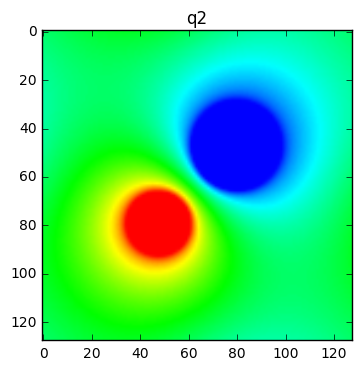

In [1024]:
# This code block prints the current graph of the interface

#1D
#plt.rcParams['figure.figsize'] = 6, 4
#plt.title('Quaternions')
#plt.plot(reference,phi[40], 'b')
#plt.plot(reference,c[40], 'r')
#plt.plot(reference,q1[40]*q1[40],'k:')
#plt.plot(reference,q2[40]*q2[40],'k--')
#plt.plot(reference,q3[40]*q3[40],'k-.')
#plt.plot(reference,q4[40]*q4[40],'k')
#plt.legend(['phi', 'c', 'q1^2', 'q2^2', 'q3^2', 'q4^2'], loc=2)
#plt.axis([0, 80, 0.05, 0.11])
#plt.savefig('graph'+str(step)+'.png')

#2D
#custom color map to match Dorr paper
colors = [(0, 0, 1), (0, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]
cm = LinearSegmentedColormap.from_list('rgb', colors)
colors2 = [(0, 0, 1), (1, 1, 0), (1, 0, 0)]
cm2 = LinearSegmentedColormap.from_list('rgb', colors2)

plt.rcParams['figure.figsize'] = 4, 4
plt.title('phi')
plt.imshow(phi, cmap=cm2)
plt.savefig('phi'+str(step)+'.png')
plt.title('q2')
plt.imshow(q2, cmap=cm)
plt.savefig('q'+str(step)+'.png')

In [991]:
#This code block saves the arrays to .npy files, as a checkpointing method

saveArrays("data/", step, c, phi, q1, q2, q3, q4)

In [1015]:
#This load block loads a previously saved array
step, c, phi, q1, q2, q3, q4 = loadArrays('data/',300000)

In [995]:
print(step)

300000


In [997]:
#this code block loads the previously saved .npy files, and writes them to .csv files for more portability

for i in range(801):
    print(i)
    ts = 300000+100*i
    step, c, phi, q1, q2, q3, q4 = loadArrays('data/',ts)
    file = open("csv/data"+str(i)+".csv", "w")
    file.write("x,y,c,phi,q1,q2,q3,q4\n")
    for j in range(128):
        for k in range(128):
            file.write(str(j)+","+str(k)+","+str(round(c[j][k], 3))+","+str(round(phi[j][k], 3))+","+str(round(q1[j][k], 3))+","+str(round(q2[j][k], 3))+","+str(round(q3[j][k], 3))+","+str(round(q4[j][k], 3))+"\n")
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27